In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import keras
from sklearn.model_selection import train_test_split
from keras_tqdm import TQDMNotebookCallback
tqdm.pandas()

base_skin_dir = '../data/HAM10000'
img_size = (96,128)

In [2]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

lesion_id      image_id  dx    dx_type   age   sex localization  \
9456  HAM_0000675  ISIC_0033418  nv  consensus  35.0  male      abdomen   
4231  HAM_0005589  ISIC_0026224  nv  follow_up  45.0  male         foot   
4716  HAM_0001774  ISIC_0029073  nv  follow_up  60.0  male         neck   

                                          path         cell_type  \
9456  ../data/HAM10000\Images\ISIC_0033418.jpg  Melanocytic nevi   
4231  ../data/HAM10000\Images\ISIC_0026224.jpg  Melanocytic nevi   
4716  ../data/HAM10000\Images\ISIC_0029073.jpg  Melanocytic nevi   

      cell_type_idx  
9456              4  
4231              4  
4716              4

In [4]:
tile_df.describe(exclude=[np.number])

lesion_id      image_id     dx dx_type    sex localization  \
count         10015         10015  10015   10015  10015        10015   
unique         7470         10015      7       4      3           15   
top     HAM_0001863  ISIC_0029890     nv   histo   male         back   
freq              6             1   6705    5340   5406         2192   

                                            path         cell_type  
count                                      10015             10015  
unique                                     10015                 7  
top     ../data/HAM10000\Images\ISIC_0033731.jpg  Melanocytic nevi  
freq                                           1              6705

In [5]:
tile_df['cell_type'].value_counts()

Melanocytic nevi                  6705
dermatofibroma                    1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [6]:
# load in all of the images
def load_resize_img(path):
    return np.array(Image.open(path).resize(reversed(img_size)))
tile_df['image'] = tile_df['path'].progress_map(load_resize_img)

100%|██████████| 10015/10015 [00:42<00:00, 233.30it/s]


# Show off a few in each category

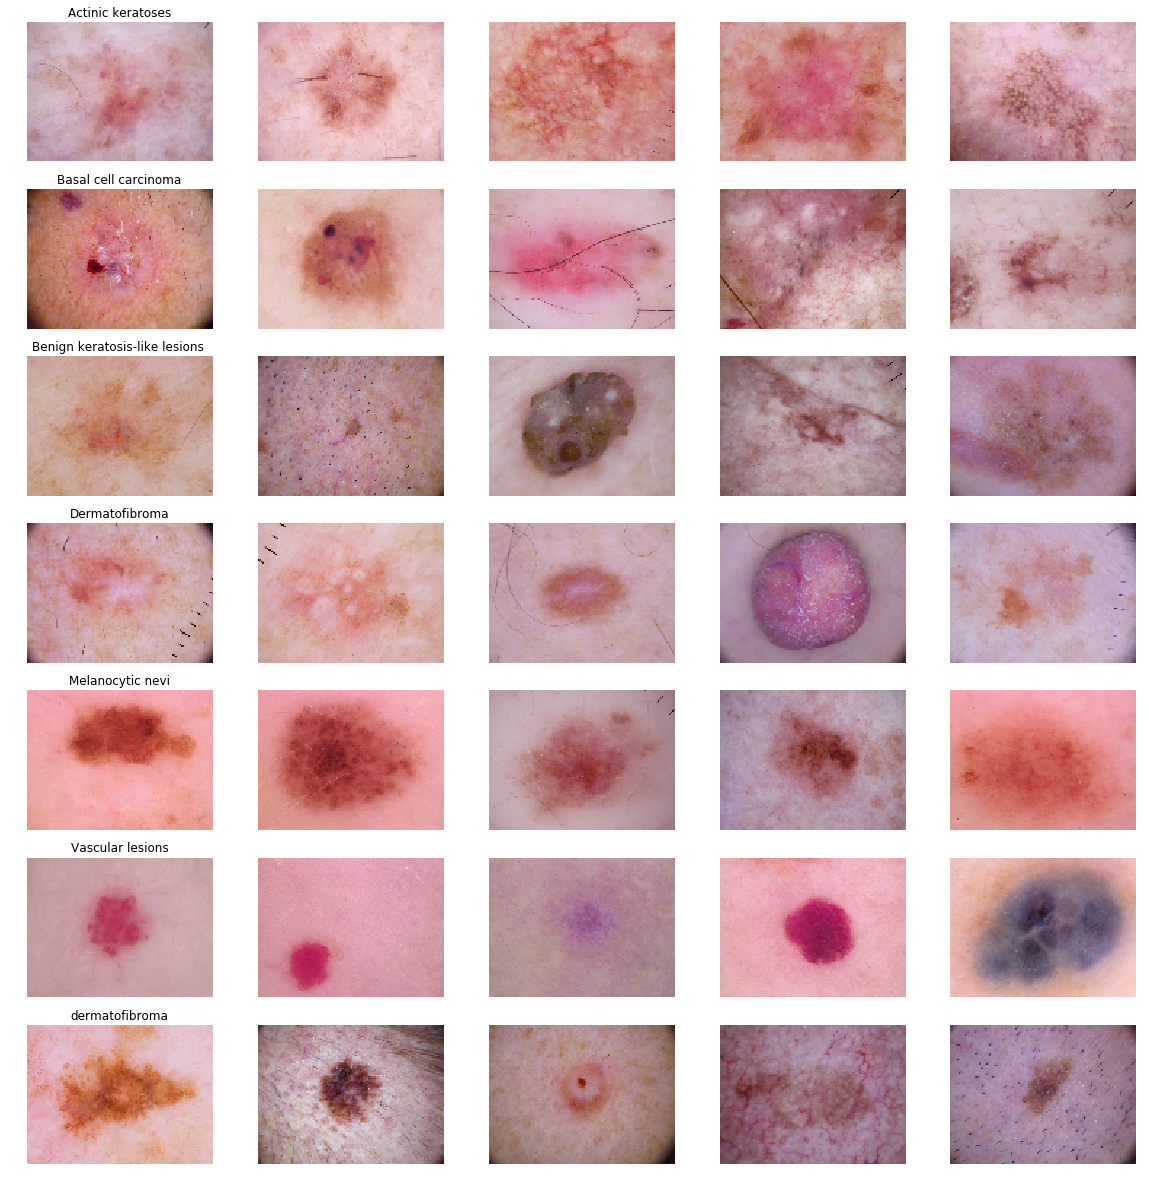

In [8]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

## Get Average Color Information
Here we get and normalize all of the color channel information

In [9]:
rgb_info_df = tile_df.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.sample(3)

Red_mean  Green_mean  Blue_mean   Gray_mean
7951  1.063789    0.928109   1.008102  157.544108
365   1.165756    0.921527   0.912717  148.182644
5966  1.281234    0.825510   0.893256  177.693278

In [10]:
for c_col in rgb_info_df.columns:
    tile_df[c_col] = rgb_info_df[c_col].values # we cant afford a copy

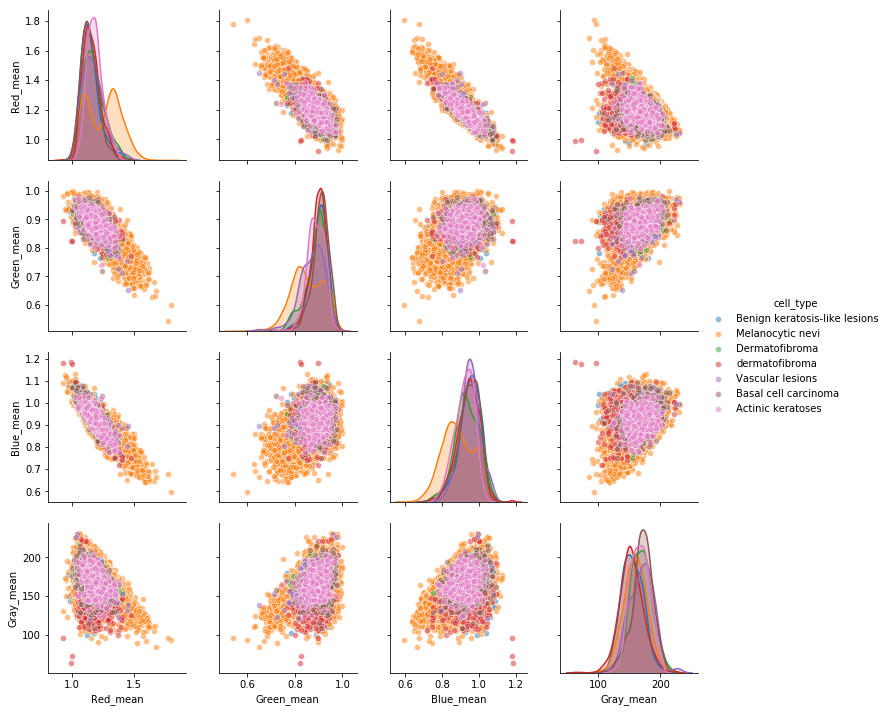

In [11]:
sns.pairplot(tile_df[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']], 
             hue='cell_type', plot_kws = {'alpha': 0.5})

# Show Color Range
Show how the mean color channel values affect images

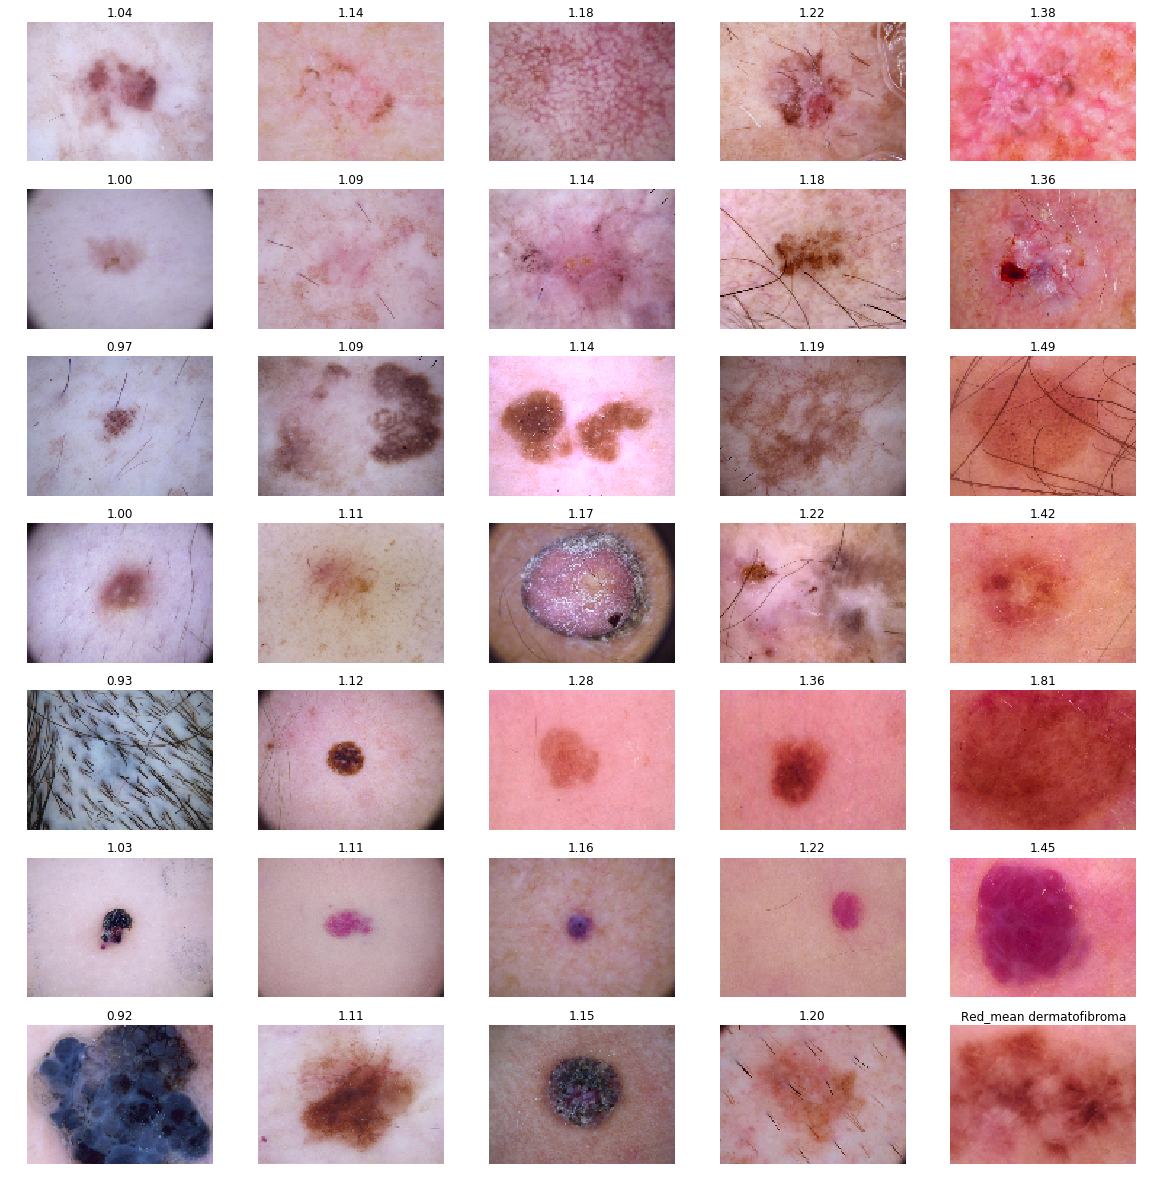

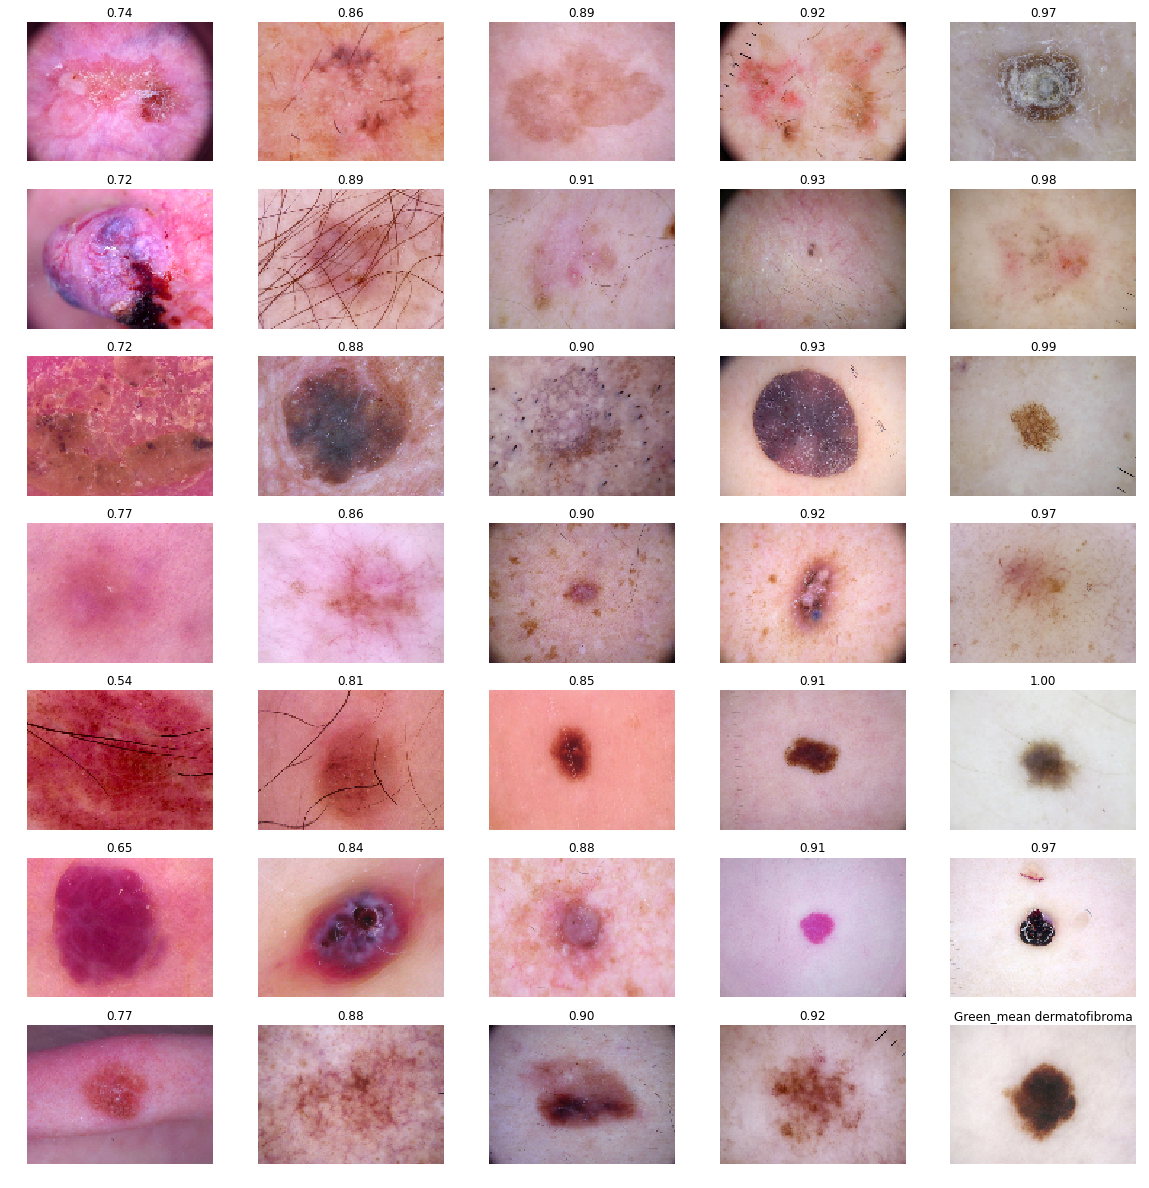

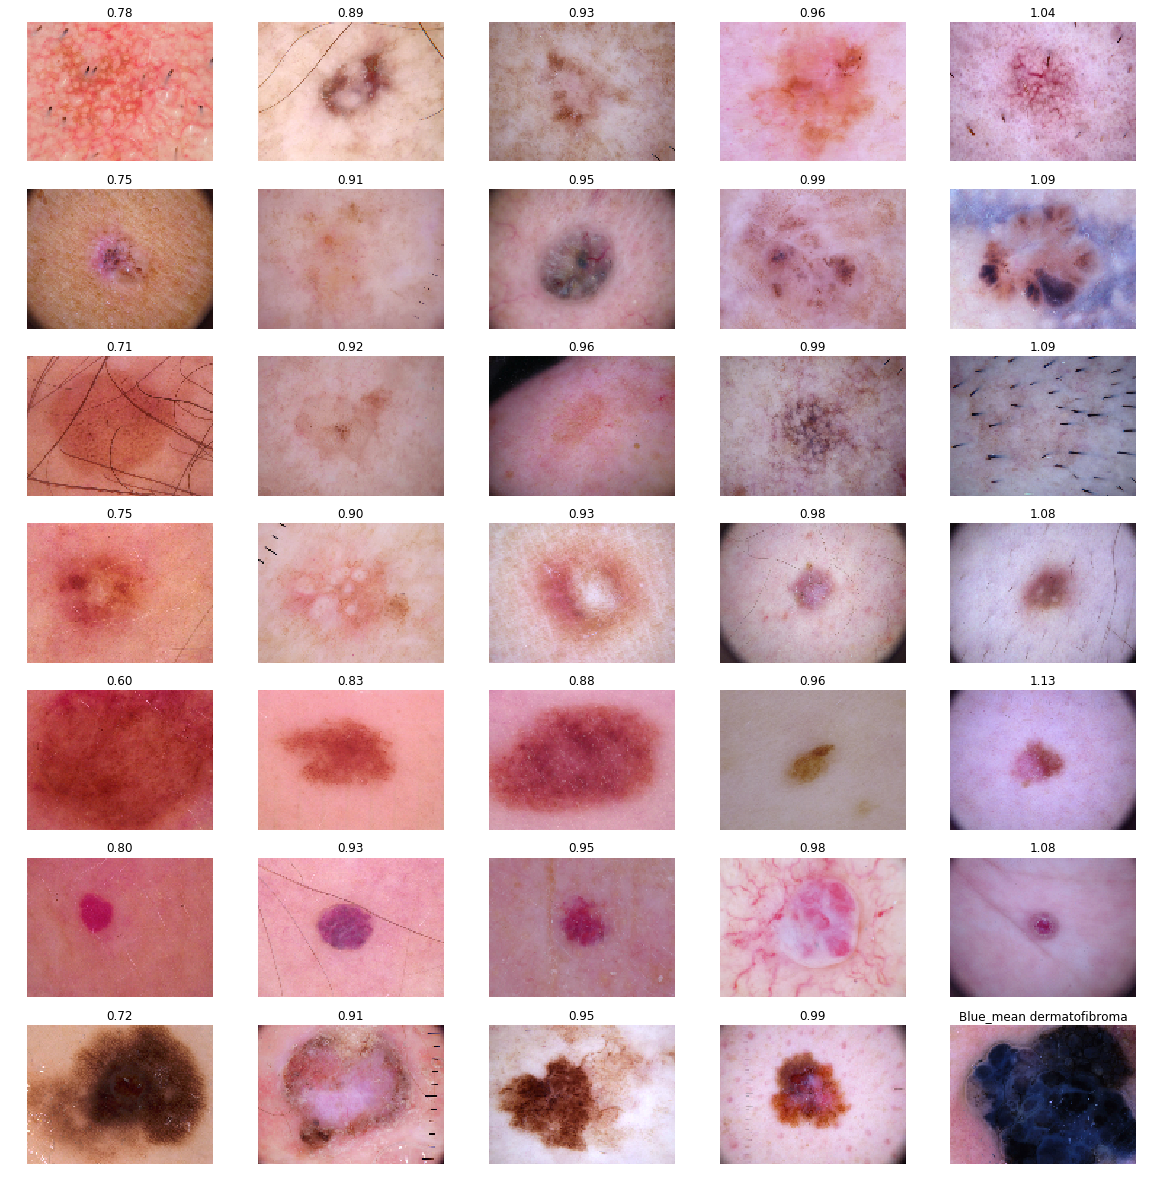

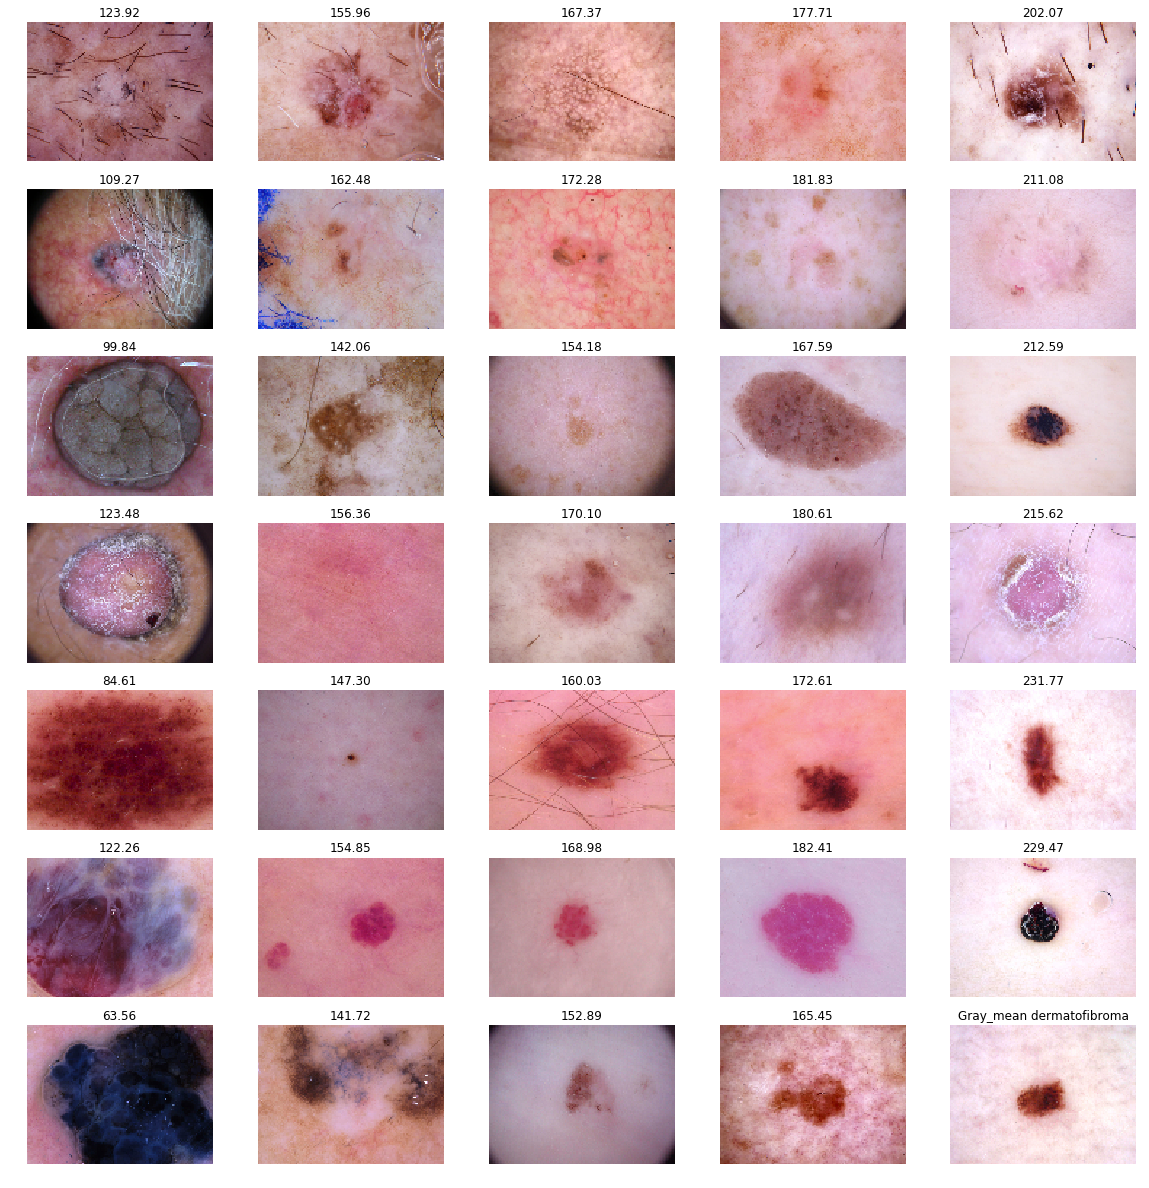

In [12]:
n_samples = 5
for sample_col in ['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean']:
    fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
    def take_n_space(in_rows, val_col, n):
        s_rows = in_rows.sort_values([val_col])
        s_idx = np.linspace(0, s_rows.shape[0]-1, n, dtype=int)
        return s_rows.iloc[s_idx]
    for n_axs, (type_name, type_rows) in zip(m_axs, 
                                             tile_df.sort_values(['cell_type']).groupby('cell_type')):

        for c_ax, (_, c_row) in zip(n_axs, 
                                    take_n_space(type_rows, 
                                                 sample_col,
                                                 n_samples).iterrows()):
            c_ax.imshow(c_row['image'])
            c_ax.axis('off')
            c_ax.set_title('{:2.2f}'.format(c_row[sample_col]))
        plt.title(' '.join([sample_col,type_name]))

# CNN

In [62]:
tile_df = tile_df.groupby(['cell_type']).apply(lambda x: x.sample(300, replace = True)
                                                      ).reset_index(drop = True)

In [63]:
train_df, test_df = train_test_split(tile_df, 
                                   test_size = 0.2, 
                                   random_state = 2018,
                                   stratify = tile_df['cell_type'])

In [19]:
X_train = np.stack(train_df['image'].values)
X_test = np.stack(test_df['image'].values)

y_train = pd.Categorical(train_df['cell_type']).codes.astype(np.uint8)
y_test = pd.Categorical(test_df['cell_type']).codes.astype(np.uint8)

In [20]:
X_mean, X_std = (np.mean(X_train,axis=(0,1,2)),np.std(X_train,axis=(0,1,2)))
X_train_s = X_train.copy()
X_test_s = X_test.copy()
for i in range(3):
    X_train_s[:,:,:,i] = (X_train[:,:,:,i] - X_mean[i])/X_std[i]
    X_test_s[:,:,:,i] = (X_test[:,:,:,i] - X_mean[i])/X_std[i]

In [21]:
gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, shear_range=0.1, zoom_range=0.1, rotation_range=45)

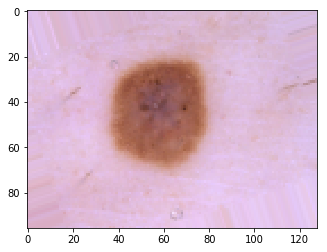

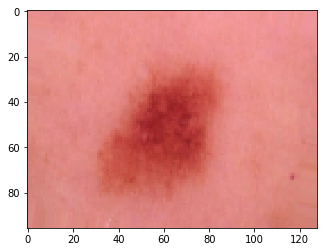

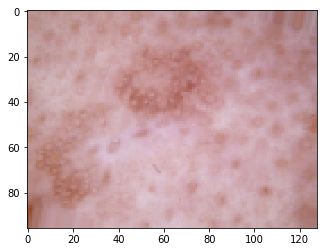

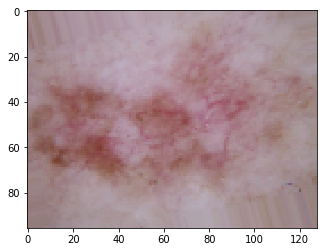

In [22]:
samples,_ = gen.flow(X_train,y_train, batch_size=4)[0]
for i in range(4):
    plt.imshow(samples[i]/255)
    plt.show()

In [48]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(*img_size,3)))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(7, activation='softmax'))

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 96, 128, 64)       1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 96, 128, 64)       36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 48, 64, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 48, 64, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 48, 64, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 48, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 24, 32, 128)       0         
__________

In [57]:
model.compile('sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [58]:
callbacks = [keras.callbacks.EarlyStopping(restore_best_weights = True, patience = 3),
            keras.callbacks.ModelCheckpoint('../models/keras_model.h5',save_best_only=True),
            TQDMNotebookCallback()]

In [59]:
batch_size = 64

In [60]:
history = model.fit_generator(
    gen.flow(X_train_s,y_train, batch_size=batch_size),epochs=20,
    callbacks = callbacks,
    validation_data=(X_test_s,y_test),
    workers=6,
    steps_per_epoch = len(X_train)//batch_size,
    verbose=0)

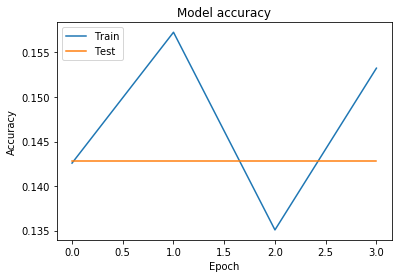

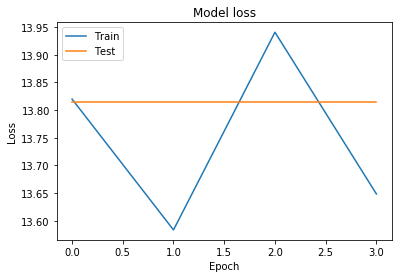

In [61]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [56]:
pd.DataFrame(history.history)

val_loss   val_acc       loss       acc
0  13.839445  0.135714  13.261677  0.144531
1  13.815542  0.142857  13.713379  0.149194
2  13.815510  0.142857  14.070837  0.127016
3  13.815510  0.142857  13.908356  0.137097
4  13.815510  0.142857  13.323426  0.173387
5  13.815510  0.142857  14.168326  0.120968